In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# `Logit` on Orders - A warm-up challenge (~1h)

## Select features

🎯 Let's figure out the impact of `wait_time` and `delay_vs_expected` on very `good/bad reviews`

👉 Using our `orders` training_set, we will run two `multivariate logistic regressions`:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

 

In [20]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

👉 Import your dataset:

In [21]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

/Users/taniagretton/code/TaniaGretton/data-context-and-setup/olist/order.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'],format='%Y-%m-%d %H:%M:%S')
/Users/taniagretton/code/TaniaGretton/data-context-and-setup/olist/order.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'],format='%Y-%m-%d %H:%M:%S')
/Users/taniagretton/code/TaniaGretton/data-c

👉 Select in a list which features you want to use:

⚠️ Make sure you are not creating data leakage (i.e. selecting features that are derived from the target)

💡 To figure out the impact of `wait_time` and `delay_vs_expected` we need to control for the impact of other features, include in your list all features that may be relevant

In [22]:
# YOUR CODE HERE
features = ['wait_time','delay_vs_expected','distance_seller_customer','number_of_sellers','price',"freight_value"]
features

['wait_time',
 'delay_vs_expected',
 'distance_seller_customer',
 'number_of_sellers',
 'price',
 'freight_value']

In [23]:
orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037


🕵🏻 Check the `multi-colinearity` of your features, using the `VIF index`.

* It shouldn't be too high (< 10 preferably) to ensure that we can trust the partial regression coefficents and their associated `p-values` 
* Do not forget to standardize your data ! 
    * A `VIF Analysis` is made by regressing a feature vs. the other features...
    * So you want to `remove the effect of scale` so that your features have an equal importance before running any linear regression!
    
    
📚 <a href="https://www.statisticshowto.com/variance-inflation-factor/">Statistics How To - Variance Inflation Factor</a>

📚  <a href="https://online.stat.psu.edu/stat462/node/180/">PennState - Detecting Multicollinearity Using Variance Inflation Factors</a>

⚖️ Standardizing:

In [24]:
# YOUR CODE HERE
orders_scaled = orders.copy()
orders_scaled = orders
#orders_scaled
for feature in features:
    mu = orders[feature].mean()
    sigma = orders[feature].std()
    orders_scaled[feature] = orders_scaled[feature].apply(lambda x: (x-mu)/sigma)

orders_scaled

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431192,15.544063,-0.161781,delivered,0,0,4,1,-0.264595,-0.513802,-0.652038,-0.979475
1,53cdb2fc8bc7dce0b6741e2150273451,0.134174,19.137766,-0.161781,delivered,0,0,4,1,-0.264595,-0.086640,0.000467,0.429743
2,47770eb9100c2d0c44946d9cf07ec65d,-0.329907,26.639711,-0.161781,delivered,1,0,5,1,-0.264595,0.111748,-0.164053,-0.145495
3,949d5b44dbf5de918fe9c16f97b45f8a,0.073540,26.188819,-0.161781,delivered,1,0,5,1,-0.264595,-0.441525,0.206815,2.054621
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.019535,12.112049,-0.161781,delivered,1,0,5,1,-0.264595,-0.562388,-0.652038,-0.959115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95875,9c5dedf39a927c1b2549525ed64a053c,-0.454309,18.587442,-0.161781,delivered,1,0,5,1,-0.264595,-0.311513,-0.449408,-0.893033
95876,63943bddc261676b46f01ca7ac2f7bd8,1.023841,23.459051,-0.161781,delivered,0,0,4,1,-0.264595,0.183977,-0.123156,-0.212797
95877,83c1379a015df1e13d02aae0204711ab,1.305780,30.384225,-0.161781,delivered,1,0,5,1,-0.264595,0.333684,1.964490,0.617630
95878,11c177c8e97725db2631073c19f07b62,0.483664,37.105243,-0.161781,delivered,0,0,2,2,1.601605,1.075186,2.715522,-0.387558


👉 Run your VIF Analysis to analyze the potential multicolinearities:

In [25]:
# YOUR CODE HERE
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [26]:
df = pd.DataFrame()

df["features"] = orders_scaled[features].columns

df["vif_index"] = [vif(orders_scaled[features].values, i) for i in range(orders_scaled[features].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
0,wait_time,2.62
1,delay_vs_expected,2.21
5,freight_value,1.67
2,distance_seller_customer,1.44
3,number_of_sellers,1.28
4,price,1.21


## Logistic Regressions

👉 Fit two `Logistic Regression` models:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

`Logit 1️⃣`

In [27]:
# YOUR CODE HERE
logit1 = smf.logit(formula='dim_is_one_star ~' +' + '.join(features), data=orders_scaled).fit()
logit1.params

Optimization terminated successfully.
         Current function value: 0.276012
         Iterations 7


Intercept                  -2.449757
wait_time                   0.686900
delay_vs_expected           0.267251
distance_seller_customer   -0.171774
number_of_sellers           0.301781
price                       0.049164
freight_value              -0.018667
dtype: float64

`Logit 5️⃣`

In [28]:
# YOUR CODE HERE
logit5 = smf.logit(formula='dim_is_five_star ~' + '+'.join(features), data=orders_scaled).fit()
logit5.params

Optimization terminated successfully.
         Current function value: 0.638779
         Iterations 7


Intercept                   0.338796
wait_time                  -0.511422
delay_vs_expected          -0.438229
distance_seller_customer    0.084898
number_of_sellers          -0.177838
price                       0.021506
freight_value               0.002551
dtype: float64

💡 It's time to analyse the results of these two logistic regressions:

- Interpret the partial coefficients in your own words.
- Check their statistical significances with `p-values`
- Do you notice any differences between `logit_one` and `logit_five` in terms of coefficient importances?

In [29]:
# Among the following sentences, store the ones that are true in the list below

a = "delay_vs_expected influences five_star ratings even more than one_star ratings"
b = "wait_time influences five_star ratings even more more than one_star"

your_answer = [a]

🧪 __Test your code__

In [30]:
from nbresult import ChallengeResult

result = ChallengeResult('logit',
    answers = your_answer
)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/taniagretton/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/taniagretton/code/TaniaGretton/data-logit/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_logit.py::TestLogit::test_question PASSED                           [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/logit.pickle

git commit -m 'Completed logit step'

git push origin master



<details>
    <summary>- <i>Explanations and advanced concepts </i> -</summary>


> _All other thing being equal, the `delay factor` tends to increase the chances of getting stripped of the 5-star even more so than it affect the chances of 1-star reviews. Probably because 1-stars are really targeting bad products themselves, not bad deliveries_
    
❗️ However, to be totally rigorous, we have to be **more careful when comparing coefficients from two different models**, because **they might not be based on similar populations**!
    We have 2 sub-populations here: (people who gave 1-stars; and people who gave 5-stars) and they may exhibit intrinsically different behavior patterns. It may well be that "happy-people" (who tends to give 5-stars easily) are less sensitive as "grumpy-people" (who shoot 1-stars like Lucky-Luke), when it comes to "delay", or "price"...

</details>


## Logistic vs. Linear ?

👉 Compare the coefficients obtained from:
- A `Logistic Regression` to explain `dim_is_five_star`
- A `Linear Regression` to explain `review_score` 

Make sure to use the same set of features for both regressions.  

⚠️ Check that both sets of coefficients  tell  "the same story".

> YOUR ANSWER HERE

In [31]:
# YOUR CODE HERE
#linear regression
linear_model = smf.ols('review_score ~'+ ' + '.join(features), data=orders_scaled).fit()

In [32]:
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     2502.
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:44:26   Log-Likelihood:            -1.5311e+05
No. Observations:               95872   AIC:                         3.062e+05
Df Residuals:                   95865   BIC:                         3.063e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [33]:
print(logit5.summary())

                           Logit Regression Results                           
Dep. Variable:       dim_is_five_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95865
Method:                           MLE   Df Model:                            6
Date:                Fri, 22 Mar 2024   Pseudo R-squ.:                 0.05517
Time:                        12:44:26   Log-Likelihood:                -61241.
converged:                       True   LL-Null:                       -64817.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3388      0.007     47.435      0.000       0.325       0.353
wait_time                   -0.5114      0.012    -43.921      0.000      -0.534      -0.

<AxesSubplot:title={'center':'Logit'}>

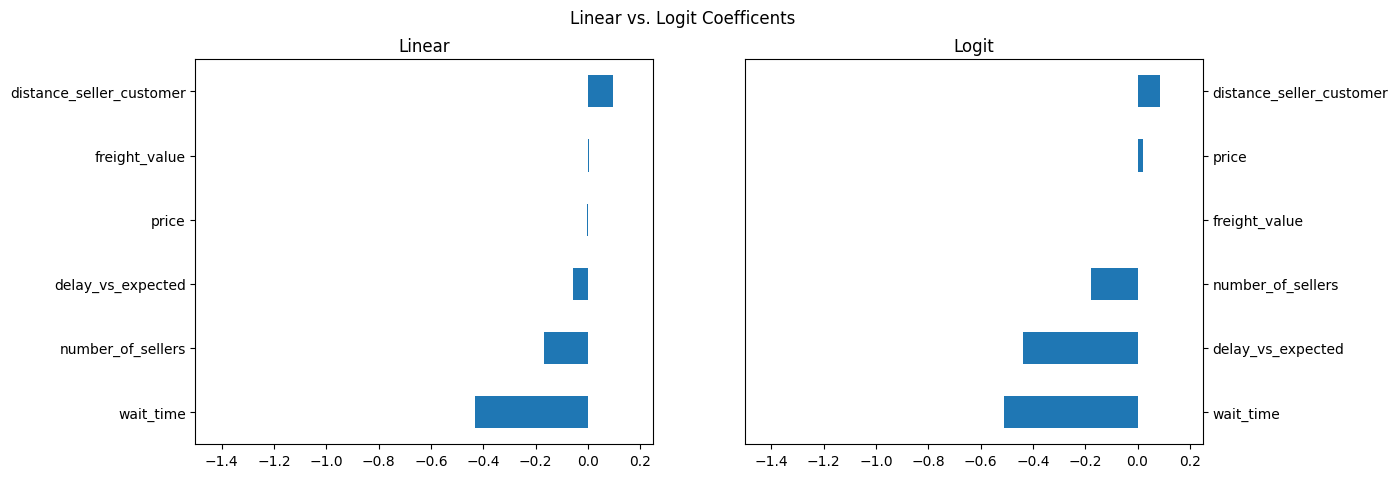

In [34]:
plt.figure(figsize=(13,5))
plt.suptitle('Linear vs. Logit Coefficents')
ax1 = plt.subplot(1,2,1)
ax1.set_title('Linear')
ax1.set_xlim(-1.5, 0.25)
linear_model.params[1:].sort_values().plot(kind='barh', ax=ax1)


ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit')
ax2.yaxis.tick_right()
ax2.set_xlim(-1.5, 0.25)
logit5.params[1:].sort_values().plot(kind='barh', ax=ax2)

🏁 Congratulations! 

💾 Don't forget to commit and push your `logit.ipynb` notebook !